In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import keras
from keras.models import Model,load_model
from keras import layers
from keras.layers import (Input,Activation,Concatenate,Add,Dropout,BatchNormalization,Conv2D,DepthwiseConv2D
                        ,ZeroPadding2D,AveragePooling2D,Lambda,Conv2DTranspose, MaxPooling2D, concatenate
                        ,Dropout,UpSampling2D,Flatten)
from keras.engine import Layer,InputSpec
from keras.engine.topology import get_source_inputs
from keras.applications import imagenet_utils
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

import pandas as pd

import math
import random
from random import randint

from sklearn.utils import class_weight

import albumentations as A

from PIL import Image

import cv2
import os
import glob

import tensorflow as tf
import tensorflow_probability as tfp

from keras import backend as K
from keras.backend.tensorflow_backend import set_session

import gc
import keras
from keras.layers import Lambda, Input, Dense, LeakyReLU, Concatenate,Dropout,RepeatVector,Reshape,Flatten
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy, mse
from keras.utils import plot_model
from keras.optimizers import Adam
from keras import backend as K
from keras.datasets import mnist
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize as norm
from collections import Counter
from keras import callbacks

import random
from pandas import read_csv
from sklearn.preprocessing import Binarizer

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [2]:
#Shape of image: i.e. the image will be RESIZE X RESIZE
RESIZE = 28

# Number of latent z's
LATENT_DIM = 300

# Number of neurons in each hidden layer
INTERMEDIATE_DIM = 1000

# Number of classes
CLASSES = 10

# Number of monte  carlo samples (see paper)
MC_SAMPLES = 1

BATCH_SIZE = 200

In [3]:
def M2():
    #Shape of flattened image
    input_shape=(RESIZE*RESIZE,)
    #inputs
    img_input = Input(shape=input_shape)
    #labels with empty second half
    y_full = Input(shape=(CLASSES,))
    #labels with empty labels removed
    y_input,y_val = Lambda(lambda x:  tf.split(x,num_or_size_splits=2,axis=0))(y_full)
    
    def gaussian_sampling(args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian.

        # Arguments
            args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector
        """
        z_mean, z_log_var = args
        z_mean_repeat = RepeatVector(MC_SAMPLES)(z_mean)
        z_log_var_repeat = RepeatVector(MC_SAMPLES)(z_log_var)
        epsilon = K.random_normal(shape=K.shape(z_mean_repeat))
        z_sample = z_mean_repeat + K.exp(0.5 * z_log_var_repeat) * epsilon
        return z_sample
    
    
    #Implements a q(y|x) NN with two hidden units that outputs the probability of each img being a certain label
    q_y__x_layer1 = Dense(INTERMEDIATE_DIM)(img_input)
    q_y__x_layer1_act =LeakyReLU(alpha = .03)(q_y__x_layer1)
    q_y__x_layer2 = Dense(INTERMEDIATE_DIM)((q_y__x_layer1_act))
    q_y__x_layer2_act = LeakyReLU(alpha = .03)(q_y__x_layer2)
    q_y__x_output = Dense(CLASSES, activation = 'softmax',name = 'q_y__x')(q_y__x_layer2_act)
    
    # Seperates out the predictions that we have labels for and those that we do not
    y_sup,y_un= Lambda(lambda x:  tf.split(x,num_or_size_splits=2,axis=0))(q_y__x_output) 
    # For the integrating out approach, we repeat the input matrix x, and construct a target (bs * n_y) x n_y
    # Example of input and target matrix for a 3 class problem and batch_size=2. 2D tensors of the form
    #               x_repeat                     t_repeat
    #  [[x[0,0], x[0,1], ..., x[0,n_x]]         [[1, 0, 0]
    #   [x[1,0], x[1,1], ..., x[1,n_x]]          [1, 0, 0]
    #   [x[0,0], x[0,1], ..., x[0,n_x]]          [0, 1, 0]
    #   [x[1,0], x[1,1], ..., x[1,n_x]]          [0, 1, 0]
    #   [x[0,0], x[0,1], ..., x[0,n_x]]          [0, 0, 1]
    #   [x[1,0], x[1,1], ..., x[1,n_x]]]         [0, 0, 1]]
    one_hot = Lambda( lambda x: K.constant(np.eye(CLASSES, dtype=int)))(img_input)
    #if garbage values change tile to repeat
    dummy_y = Lambda( lambda x: K.tile(x, [(BATCH_SIZE//2),1] ))(one_hot)
    
    y = Concatenate(axis=0)([y_input,dummy_y])
    
    # turn x,y,z into x,x,x,y,y,y,z,z,z with the number of repeats being the number of classes
    img_sup,img_un =Lambda(lambda x:  tf.split(x,num_or_size_splits=2,axis=0))(img_input) 
    rep_img_un = Lambda(lambda x: K.repeat_elements(x,rep=CLASSES,axis = 0))(img_un)
    rep_img_input = Concatenate(axis=0)([img_sup,rep_img_un])
    
    #Implements a q(z|y,x) NN with two hidden units that outputs the parameters to a gaussian distribution
    # for labeled data and for unlabeled outputs parameters for each possible y
    q_z__y_x_concat = Concatenate()([rep_img_input,y])
    q_z__y_x_layer1 = Dense(INTERMEDIATE_DIM)(q_z__y_x_concat)
    q_z__y_x_layer1_act = LeakyReLU(alpha = .03)(q_z__y_x_layer1)
    q_z__y_x_layer2 = Dense(INTERMEDIATE_DIM)(q_z__y_x_layer1_act)
    q_z__y_x_layer2_act = LeakyReLU(alpha = .03)(q_z__y_x_layer2)
    q_z__y_x_mean = Dense(LATENT_DIM,name = 'q_z__y_x_mean')(q_z__y_x_layer2_act)
    rep_q_z__y_x_mean = RepeatVector(MC_SAMPLES)(q_z__y_x_mean)
    q_z__y_x_log_var = Dense(LATENT_DIM,name = 'q_z__y_x_log_var')(q_z__y_x_layer2_act)
    rep_q_z__y_x_log_var = RepeatVector(MC_SAMPLES)(q_z__y_x_log_var)
    q_z__y_x_output = Lambda(gaussian_sampling,name = 'q_z__y_x')([q_z__y_x_mean,q_z__y_x_log_var])

    # Implements a p(x|y,z) NN with two hidden units that outputs the parameters to a bernoulli distribution
    # for labeled data and for unlabeled outputs parameters for each possible y
    p_x__y_z_concat = Concatenate()([y ,Flatten()(q_z__y_x_output)])
    p_x__y_z_layer1 = Dense(INTERMEDIATE_DIM)(p_x__y_z_concat)
    p_x__y_z_layer1_act = LeakyReLU(alpha = .03)(p_x__y_z_layer1)
    p_x__y_z_layer2 = Dense(INTERMEDIATE_DIM)(p_x__y_z_layer1_act)
    p_x__y_z_layer2_act = LeakyReLU(alpha = .03)(p_x__y_z_layer2)
    p_x__y_z_mean = Dense(RESIZE*RESIZE,activation = 'sigmoid',name = 'p_x__y_z_mean')(p_x__y_z_layer2_act)
    #p_x__y_z_log_var = Dense(resize*resize,name = 'p_x__a_y_z_log_var')(p_x__a_y_z_layer2_act)
    #p_x__y_z_output = Lambda(gaussian_sampling,name = 'p_x__a_y_z')([p_x__a_y_z_mean, p_x__a_y_z_log_var]) 
    
    def gaussian_ll(args):
        # Calculates the log liklihood of a point x under a gaussian distribution parameterized by mu and log_var
        x , mu, log_var = args
        
        c = -.5 * math.log(2*math.pi)
        density = c - log_var/2 - ((x - mu)/(2*K.exp(log_var) + 1e-8))*(x - mu)

        return K.sum(density,axis = -1)
    
    def unit_gaussian_ll(args):
        # Calculates the log liklihood of a point x under a unit gaussian distribution
        x = args
        
        c = -.5 * math.log(2*math.pi)
        density = c - (x)**2/2

        return K.sum(density,axis = -1)

        
    def log_pz(y_true,y_pred):
        # Calculates the log liklihood that the sampled 'z' is under the unit gaussian distributions 
        #, then weights the unsupervised samples according to how likely their asscociated y value was.
        # (as predicted by p(y|x))
        flat_y_un = K.reshape(y_un,shape = [-1])
        ones = K.ones(shape = (BATCH_SIZE//2))
        weights = K.concatenate([ones,flat_y_un],0)
        loss_per_point = weights*K.mean(unit_gaussian_ll(q_z__y_x_output),axis = 1)
        split = tf.split(loss_per_point, num_or_size_splits=CLASSES+1 ,axis=0)
        sup_loss = split[0]
        un = K.concatenate(split[1:])
        un_loss = K.sum(K.reshape(un,[BATCH_SIZE//2,CLASSES]),axis = 1)
        loss = K.concatenate([sup_loss,un_loss])
        return loss
        
        
    def log_qz(y_true,y_pred):
        # Calculates the log liklihood that the sampled 'z' is under the gaussian distributions predicted by
        # q(z|y,x), then weights the unsupervised sampled according to how likely their asscociated y value was
        #(as predicted by p(y|x))
        flat_y_un = K.reshape(y_un,shape = [-1])
        ones = K.ones(shape = (BATCH_SIZE//2))
        weights = K.concatenate([ones,flat_y_un],0)
        loss_per_point = weights*K.mean(gaussian_ll([q_z__y_x_output,rep_q_z__y_x_mean,rep_q_z__y_x_log_var]),axis = 1)
        split = tf.split(loss_per_point, num_or_size_splits=CLASSES+1 ,axis=0)
        sup_loss = split[0]
        un = K.concatenate(split[1:])
        un_loss = K.sum(K.reshape(un,[BATCH_SIZE//2,CLASSES]),axis = 1)
        loss = K.concatenate([sup_loss,un_loss])

        return loss
    
    def log_py(y_true,y_pred):
        # Calculates the log liklihood that the all possible 'y' is under y's true distribution WHICH
        # IS ASSUMED TO BE BALANCED CATAGORICLE, then weights the unsupervised sampled according to 
        #how likely their asscociated y value was (as predicted by p(y|x)).
        flat_y_un = K.reshape(y_un,shape = [-1])
        ones = K.ones(shape = (BATCH_SIZE//2))
        weights = K.concatenate([ones,flat_y_un],0)
        expected = K.ones_like(q_y__x_output)/CLASSES
        concat = K.concatenate([y_input,y_un])
        loss_per_point = K.categorical_crossentropy(expected,q_y__x_output)
        return -loss_per_point
        
    
    def log_px(y_true,y_pred):
        # Calculates the log liklihood that the true images is under the gaussian distributions predicted by
        # p(x|a,y,z), then weights the unsupervised sampled according to how likely their asscociated y value was
        #(as predicted by p(y|a,x))
        flat_y_un = K.reshape(y_un,shape = [-1])
        ones = K.ones(shape = ((BATCH_SIZE//2)))
        weights = K.concatenate([ones,flat_y_un],0)
        loss_per_point = -weights*keras.losses.binary_crossentropy(rep_img_input,p_x__y_z_mean)
        split = tf.split(loss_per_point, num_or_size_splits=CLASSES+1 ,axis=0)
        sup_loss = split[0]
        un = K.concatenate(split[1:])
        un_loss = K.sum(K.reshape(un,[BATCH_SIZE//2,CLASSES]),axis = 1)
        loss = K.concatenate([sup_loss,un_loss])
        return loss
    
    def y_ent(y_true,y_pred):
        # Caluclates the entropy of the unsupervised predicted y values
        
        flat_y_un = K.reshape(y_un,shape = [-1])
        zero = K.zeros(shape = ((BATCH_SIZE//2)))
        un = flat_y_un*K.log(flat_y_un)
        un_loss = K.sum(K.reshape(un,[BATCH_SIZE//2,CLASSES]),axis = 1)

        loss = K.concatenate([zero,un_loss])
        return -loss
       
    def acc(y_true,y_pred):
        # Calculates the raw accuracy of our y prediction for the images that we have labels for

        return K.mean(keras.metrics.categorical_accuracy(y_input,y_sup))
    
    def y_class(y_true,y_pred):
        # Calculates a supervised loss for the y predictions for the images that we have labels for
        zero = K.zeros(shape = (BATCH_SIZE//2))
        sup_loss = K.categorical_crossentropy(y_input,y_sup)

        loss = K.concatenate([sup_loss,zero])
        return loss
    
    
    def qy_loss(y_true,y_pred):
        return K.mean(1*y_ent(y_true,y_pred) + -1*log_py(y_true,y_pred) + 10*y_class(y_true,y_pred))
    
    def qz_loss(y_true,y_pred):
        return K.mean(log_qz(y_true,y_pred) + -1*log_pz(y_true,y_pred))
    
    def px_loss(y_true,y_pred):
        return K.mean(-log_px(y_true,y_pred))
    
        
    losses = {'q_y__x': qy_loss,'q_z__y_x': qz_loss, 'p_x__y_z_mean':px_loss}
    
    model = Model([img_input,y_full],[p_x__y_z_mean,q_y__x_output,q_z__y_x_output]
                  , name = 'VAE')
    model.compile(loss = losses,metrics = {'q_y__x':acc},optimizer = keras.optimizers.Adam(lr=.001,clipnorm=1.,clipvalue= .5))
    
    return model  

In [4]:
mnist_m2_vae = M2()
mnist_m2_vae.load_weights('MNIST_M2_VAE.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






In [5]:
#Shape of image: i.e. the image will be RESIZE X RESIZE
RESIZE = 28

# Number of latent z's
LATENT_DIM = 300

# Number of neurons in each hidden layer
INTERMEDIATE_DIM = 1000

# Number of classes
CLASSES = 10

BATCH_SIZE = 100

In [6]:
#Shape of flattened image
input_shape=(RESIZE*RESIZE,)

img_input = Input(shape=input_shape)

#Implements a q(y|x) NN with two hidden units that outputs the probability of each img being a certain label
y = Dense(INTERMEDIATE_DIM)(img_input)
y =LeakyReLU(alpha = .03)(y)
y = Dense(INTERMEDIATE_DIM)(y)
y = LeakyReLU(alpha = .03)(y)
y = Dense(CLASSES, activation = 'softmax')(y)

In [7]:
mnist_baseline = Model(img_input,y)
mnist_baseline.compile(loss = 'categorical_crossentropy',metrics = ['categorical_accuracy'],optimizer = keras.optimizers.Adam(lr=.001,clipnorm=1.,clipvalue= .5))
mnist_baseline.load_weights('MNIST_Baseline.h5')

In [8]:
#Shape of image: i.e. the image will be RESIZE X RESIZE
RESIZE = 128

#Number of possible classes for each pixel
CLASSES = 21
BATCH_SIZE = 16

# Used in the gumbel softmax sampling trick
TEMPERATURE = .1

In [9]:
# Much of this code comes from 
# https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py
# however it has been heavily modified


# Functions and layers that are used by the deeplab networks
class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        #self.data_format = K.normalize_data_format(data_format)
        self.data_format = None
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return K.tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return K.tf.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False)(x)

    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate)
                      )(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate)
                      )(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return K.relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None)(x)
        x = Activation(relu6)(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate))(x)

    x = Activation(relu6)(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None)(x)

    if skip_connection:
        return Add()([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x

In [10]:
def M2():

    input_shape = (RESIZE,RESIZE,3)
    alpha=1.
    img_input = Input(shape=input_shape)
    y_full = Input(shape=(RESIZE,RESIZE,CLASSES))
    y_input= Lambda(lambda x:  tf.split(x,num_or_size_splits=2,axis=0))(y_full)[0] 
    
    # A network that takes as input the given image and outputs the 
    # parameters to multinomial distributions for each pixel
    # i.e. a mask.
    # This network is refered to as q(y|x) in the paper
    OS = 8
    first_block_filters = _make_divisible(32 * alpha, 8)
    y = Conv2D(first_block_filters,
               kernel_size=3,
               strides=(2, 2), padding='same',
               use_bias=False)(img_input)
    y = Activation(relu6)(y)

    y = _inverted_res_block(y, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, skip_connection=False)

    y = _inverted_res_block(y, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, skip_connection=False)
    y = _inverted_res_block(y, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, skip_connection=True)

    y = _inverted_res_block(y, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, skip_connection=False)
    y = _inverted_res_block(y, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, skip_connection=True)
    y = _inverted_res_block(y, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, skip_connection=True)

    # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
    y = _inverted_res_block(y, filters=64, alpha=alpha, stride=1,  # 1!
                            expansion=6, block_id=6, skip_connection=False)
    y = _inverted_res_block(y, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=7, skip_connection=True)
    y = _inverted_res_block(y, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=8, skip_connection=True)
    y = _inverted_res_block(y, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=9, skip_connection=True)

    y = _inverted_res_block(y, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=10, skip_connection=False)
    y = _inverted_res_block(y, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=11, skip_connection=True)
    y = _inverted_res_block(y, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=12, skip_connection=True)

    y = _inverted_res_block(y, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                            expansion=6, block_id=13, skip_connection=False)
    y = _inverted_res_block(y, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=14, skip_connection=True)
    y = _inverted_res_block(y, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=15, skip_connection=True)

    y = _inverted_res_block(y, filters=320, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(y)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(y)
    b0 = Activation('relu')(b0)

    # there are only 2 branches in mobilenetV2. not sure why

    y = Concatenate()([b4, b0])

    y = Conv2D(256, (1, 1), padding='same',
               use_bias=False)(y)
    y = Activation('relu')(y)
    y = Dropout(0 )(y)
    
    y = Conv2D(CLASSES, (1, 1), padding='same')(y)
    y = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(y)
    
    # This is the predicted mask for each image
    y_output = Activation('softmax',name = 'q_y')(y)
    
    # Splits out the masks that have a true mask(y_sup) and those that don't(y_un)
    y_sup,y_un =Lambda(lambda x:  tf.split(x,num_or_size_splits=2,axis=0))(y_output) 

    # A function that generates samples from a set of mulitnomial distributions 
    # in a way that the gradient can propagate through.
    def gumbel_softmax(args):
        ind_multinomial = args
        gumbel_dist = tfp.distributions.RelaxedOneHotCategorical(TEMPERATURE, probs=ind_multinomial)
        return gumbel_dist.sample()
    
    # Samples from the "distribution" of the masks for the images without labels
    y_un_sample = Lambda(gumbel_softmax)(y_un)
    
    # Replaces the predicted masks for the images with labels with the true masks
    # this may seem wierd but it is what is mathematiclly correct
    y_t_un = Concatenate(axis=0)([y_input,y_un_sample])

    # END q(y|x)
    
    # A network that takes as input the half true half predicted masks as
    # well as the images as input and outputs the parameters to
    # a set of multivariate gaussian distributions
    # This network is refered to as q(z|y,x) in the paper
    ys = Concatenate(axis=-1)([y_t_un,img_input])

    OS = 8
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters,
               kernel_size=3,
               strides=(2, 2), padding='same',
               use_bias=False)(ys)

    x = Activation(relu6)(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, skip_connection=False)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, skip_connection=False)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, skip_connection=True)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, skip_connection=False)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, skip_connection=True)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, skip_connection=True)

    # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                            expansion=6, block_id=6, skip_connection=False)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=7, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=8, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=9, skip_connection=True)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=10, skip_connection=False)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=11, skip_connection=True)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=12, skip_connection=True)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                            expansion=6, block_id=13, skip_connection=False)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=14, skip_connection=True)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=15, skip_connection=True)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
    b0 = Activation('relu')(b0)

    # there are only 2 branches in mobilenetV2. not sure why

    x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = Dropout(0)(x)

    # A log(sigma) for each latent variable
    # Note that the choices of CLASSES as the width of this output
    # is somewhat arbitrary
    # Note that log(sigma) instead of sigma or sigma^2 is chosen as the output for numericle stability
    z_log_var = Conv2D(CLASSES, (1, 1), padding='same')(x)
    z_log_var = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(z_log_var)
    
    # A mean for each latent variable
    z_mean = Conv2D(CLASSES, (1, 1), padding='same')(x)
    z_mean = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(z_mean)

    
    # A function for sampling from the above gaussian distrubution
    def gaussian_sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=K.shape(z_mean))
        z_sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return z_sample
    
    # Samples form the predicted gaussian distribution
    z_sample = Lambda(gaussian_sampling,name = 'q_z')([z_mean, z_log_var])
    
    # END q(z|x,y)
    
    # A network that takes as input the above z sample and the
    # half true half predicted y and outputs the parameters to
    # a bernoulli distribution for each pixel and channel.
    # This could be interpruted as an image.
    # This is refered to as p(x|y,z) in the paper.
    x = Concatenate()([z_sample,y_t_un])
 
    input_shape = (RESIZE,RESIZE,CLASSES + CLASSES)

    OS = 8
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters,
               kernel_size=3,
               strides=(2, 2), padding='same',
               use_bias=False)(x)
    x = Activation(relu6)(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, skip_connection=False)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, skip_connection=False)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, skip_connection=True)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, skip_connection=False)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, skip_connection=True)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, skip_connection=True)

    # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                            expansion=6, block_id=6, skip_connection=False)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=7, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=8, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=9, skip_connection=True)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=10, skip_connection=False)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=11, skip_connection=True)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                            expansion=6, block_id=12, skip_connection=True)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                            expansion=6, block_id=13, skip_connection=False)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=14, skip_connection=True)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=15, skip_connection=True)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                            expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False)(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
    b0 = Activation('relu')(b0)

    # there are only 2 branches in mobilenetV2. not sure why

    x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False)(x)
    x = Activation('relu')(x)
    x = Dropout(0)(x)

    # DeepLab v.3+ decoder

    x = Conv2D(3, (1, 1), padding='same')(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)

    x = Activation('sigmoid',name = 'p_x')(x)

    # END p(x|y,z)
    
    
    # A function that calcuates the intersection over union couf.
    def iou_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(K.abs(y_input * y_sup), axis=[1,2,3])
        union = K.sum(y_input,[1,2,3])+K.sum(y_sup,[1,2,3])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou
    
    # Calculates the log liklihood of a point x under a gaussian distribution parameterized by mu and log_var
    def gaussian_ll(args):
        x , mu, log_var = args
        x = Flatten()(x)
        mu = Flatten()(mu)
        log_var = Flatten()(log_var)
        
        c = -.5 * math.log(2*math.pi)
        density = c - log_var/2 - ((x - mu)/(2*K.exp(log_var) + 1e-8))*(x - mu)

        return K.sum(density,axis = -1)
    
    # Calculates the log liklihood of a point x under a unit gaussian distribution
    def unit_gaussian_ll(args):
        x = args
        x = Flatten()(x)
        
        c = -.5 * math.log(2*math.pi)
        density = c - x**2/2

        return K.sum(density,axis = -1)

    
    # Calculates the log liklihood that the sampled 'z' is under the unit gaussian distributions 
    def log_pz(y_true,y_pred):
        loss = unit_gaussian_ll(z_sample)
        return loss
        
    
    # Calculates the log liklihood that the sampled 'z' is under the gaussian distributions predicted by
    # q(z|y,x)
    def log_qz(y_true,y_pred):
        loss = gaussian_ll([z_sample,z_mean,z_log_var])
        return loss
    
    # Calculates the log liklihood that the all possible 'y' is under y's true distribution WHICH
    # IS ASSUMED TO BE BERNOULLI WITH CONSTANT PROBABILITY 1/CLASSES FOR ALL Y
    def log_py(y_true,y_pred):
        y = Flatten()(y_t_un)
        ones = K.ones_like(y)/CLASSES
        loss = -K.binary_crossentropy(ones,y)
        loss = K.sum(loss,axis=1)
        return loss
    
    # Calculates the log liklihood that the true images is predicted by
    # p(x|y,z). Image is expected to be binarized.
    def log_px(y_true,y_pred):
        #Effectivly calculates
        #if(img_input == 1)
        #  loss = log(x)
        #else if(img_input == 0)
        #  loss = log(1 - x)
        loss = -K.binary_crossentropy(img_input,x)
        loss = K.sum(loss,axis = 1)
        return loss
    
    
    # Calculates the log liklihood that the sampled y is under the predicted y's distribution WHICH
    # IS ASSUMED TO BE BERNOULLI
    def log_qy(y_true,y_pred):
        zero = K.zeros(shape = ((BATCH_SIZE//2)))
        un = -K.binary_crossentropy(Flatten()(y_un),Flatten()(y_un_sample))
        un = K.sum(un,axis = 1)
        loss = K.concatenate([zero,un])
        return loss
       
    
    # Calculates a supervised loss for the y predictions for the images that we have labels for
    def y_class(y_true,y_pred):
        zero = K.zeros(shape = (BATCH_SIZE//2))
        sup_loss = K.binary_crossentropy(Flatten()(y_input),Flatten()(y_sup))
        sup_loss = K.sum(sup_loss,axis = 1)
        loss = K.concatenate([sup_loss,zero])
        return loss
    
    # Calculates the negative lower bounds(i.e. the minamization target) for q(y|x),q(z|x,y) and p(x|z,y)
    def y_loss(y_true,y_pred):
        return K.mean(1*log_qy(y_true,y_pred) + -1*log_py(y_true,y_pred) + 1000*y_class(y_true,y_pred))
    
    def z_loss(y_true,y_pred):
        return K.mean(log_qz(y_true,y_pred) + -1*log_pz(y_true,y_pred))
    
    def x_loss(y_true,y_pred):
        return K.mean(-log_px(y_true,y_pred))
    
    
    loss = {'p_x':x_loss,'q_z':z_loss,'q_y':y_loss}
    metrics = {'q_y':iou_coef}
    model = Model([img_input,y_full], [x,y_output,z_sample], name = 'VAE')
    model.compile(loss = loss,metrics = metrics,optimizer = keras.optimizers.Adam(lr=.1,clipnorm = 1.,clipvalue = 0.5))
    
    return model

In [11]:
pascal_voc_m2_vae = M2()
pascal_voc_m2_vae.load_weights('Pascal_Voc_M2_VAE.h5')

In [12]:
#Shape of image: i.e. the image will be RESIZE X RESIZE
RESIZE = 128
#Number of possible classes for each pixel
CLASSES = 21
BATCH_SIZE = 8

In [13]:
def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2', OS=16, alpha=1.):
    """ Instantiates the Deeplabv3+ architecture

    Optionally loads weights pre-trained
    on PASCAL VOC. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc)
            or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        classes: number of desired classes. If classes != 21,
            last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone

    # Returns
        A Keras model instance.

    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`

    """

    if not (weights in {'pascal_voc', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `pascal_voc` '
                         '(pre-trained on PASCAL VOC)')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = Activation('relu')(b4)
    b4 = BilinearUpsampling((int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = Activation('relu')(x)

    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        x = BilinearUpsampling(output_size=(int(np.ceil(input_shape[0] / 4)),
                                            int(np.ceil(input_shape[1] / 4))))(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if classes == 21:
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    x = BilinearUpsampling(output_size=(input_shape[0], input_shape[1]))(x)
    x = keras.layers.Activation('softmax')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='deeplabv3+')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model


def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return imagenet_utils.preprocess_input(x, mode='tf')

In [14]:
# Calculates the intersection over union coef between two masks
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [15]:
pascal_voc_baseline = Deeplabv3(input_shape=(RESIZE,RESIZE,3),weights = None, classes=CLASSES)
pascal_voc_baseline.compile(optimizer = keras.optimizers.Adam(lr=.1,clipnorm = 1.,clipvalue = .5), loss = 'binary_crossentropy',metrics = [iou_coef])
pascal_voc_baseline.load_weights('Pascal_Voc_Baseline.h5')

In [16]:
#Defines the augmentitations
def get_training_augmentation():
    train_transform = [
        A.Flip(p=0.5),
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),     
        A.Resize(height = RESIZE, width = RESIZE, interpolation=1, always_apply=True, p=1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.Resize(height = RESIZE, width = RESIZE, interpolation=1, always_apply=True, p=1)
    ]
    return A.Compose(test_transform)


In [17]:
# Generates the data used for validation
class MNISTValGenerator(keras.utils.Sequence):
    
    # Loads in the labeled images
    def __init__(self,batch_size = 64):
        
        self.labeled_images = read_csv("./MNIST/59900_100_balenced/val_x.csv").to_numpy()
        self.labels = read_csv("./MNIST/59900_100_balenced/val_y.csv").to_numpy()
        
        self.labeled_index = np.arange(0, len(self.labeled_images), 1).tolist()
        random.shuffle(self.labeled_index)
        
        self.batch_size = batch_size
        self.X = np.zeros((self.batch_size, 28*28), dtype='float32')
        self.Y = np.zeros((self.batch_size,10), dtype='float32')
        
    def __len__(self):
        return  len(self.labeled_index) // self.batch_size
        
    def __getitem__(self, i):
        n = 0
        for x in self.labeled_index[i*self.batch_size : (i+1)*self.batch_size]:
            
            image = self.labeled_images[x] + .5
            rand = np.random.ranf(image.shape)
            image = np.greater(image,rand).astype(int)
            label = self.labels[x]

            self.X[n] = image
            self.Y[n] = label
            n = n + 1
            
        return self.X, self.Y
        
    def on_epoch_end(self):
        pass


In [18]:
mnist_baseline_val_gen = MNISTValGenerator(200)

In [19]:
# Generates the data used for validation
class ValGenerator(keras.utils.Sequence):
    
    # Loads in the labeled images
    def __init__(self,batch_size = 64):
        
        self.labeled_images = read_csv("./MNIST/59900_100_balenced/val_x.csv").to_numpy()
        self.labels = read_csv("./MNIST/59900_100_balenced/val_y.csv").to_numpy()
        
        self.labeled_index = np.arange(0, len(self.labeled_images), 1).tolist()
        random.shuffle(self.labeled_index)
        
        self.batch_size = batch_size
        self.X = np.zeros((self.batch_size*2, 28*28), dtype='float32')
        self.Y = np.zeros((self.batch_size*2,10), dtype='float32')
        
    def __len__(self):
        return  len(self.labeled_index) // self.batch_size
        
    def __getitem__(self, i):
        n = 0
        for x in self.labeled_index[i*self.batch_size : (i+1)*self.batch_size]:
            
            image = self.labeled_images[x] + .5
            rand = np.random.ranf(image.shape)
            image = np.greater(image,rand).astype(int)
            label = self.labels[x]

            self.X[n] = image
            self.Y[n] = label
            n = n + 1
            
        return [self.X, self.Y], [self.Y,self.Y,self.Y]
        
    def on_epoch_end(self):
        pass


In [20]:
mnist_m2_vae_val_gen = ValGenerator(100)

In [21]:
# Generates the data used for validation
class ValGenerator(keras.utils.Sequence):
    
    # Loads in the labeled images
    def __init__(self,  n_classes=21, batch_size=32, resize_shape=(128,128)):
            
        self.image_path_list = os.listdir('./VOCdevkit/VOC2012/val_frames/')
        random.shuffle(self.image_path_list)
        
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.resize_shape = resize_shape
        if self.resize_shape:
            self.X = np.zeros((self.batch_size, resize_shape[1], resize_shape[0], 3), dtype='float32')
            self.Y = np.zeros((self.batch_size, resize_shape[1],resize_shape[0],n_classes), dtype='float32')
        else:
            raise Exception('No image dimensions specified!')
        
    def __len__(self):
        return len(self.image_path_list) // self.batch_size
        
    def __getitem__(self, i):
        n = 0
        
        for x in self.image_path_list[i*self.batch_size:(i+1)*self.batch_size]:
            
            image = np.array(Image.open('./VOCdevkit/VOC2012/val_frames/' + x))
            label = np.array(Image.open('./VOCdevkit/VOC2012/val_masks/' + x.replace('.jpg','.png')))

            sample = get_validation_augmentation()(image=image, mask=label)
            image, label = sample['image']/255, sample['mask']
            rand = np.random.ranf(image.shape)
            image = np.greater(image,rand).astype(int)

            categorical_label = keras.utils.to_categorical(label)

            self.X[n] = image
            #cat_label -> image
            self.Y[n] = categorical_label[:,:,0:21]
            n = n + 1

        return self.X, self.Y
        
    def on_epoch_end(self):
        random.shuffle(self.image_path_list)


In [22]:
pascal_voc_baseline_val_gen = ValGenerator(batch_size=8,n_classes = 21)

In [23]:
# Generates the data used for validation
class ValGenerator(keras.utils.Sequence):
    
    # Loads in the labeled images
    def __init__(self,  n_classes=21, batch_size=32, resize_shape=(128,128)):
            
        self.image_path_list = os.listdir('./VOCdevkit/VOC2012/val_frames/')
        random.shuffle(self.image_path_list)
        
        self.n_classes = n_classes
        self.batch_size = int(batch_size/2)
        self.resize_shape = resize_shape
        if self.resize_shape:
            self.X = np.zeros((self.batch_size*2, resize_shape[1], resize_shape[0], 3), dtype='float32')
            self.Y = np.zeros((self.batch_size*2, resize_shape[1],resize_shape[0],n_classes), dtype='float32')
        else:
            raise Exception('No image dimensions specified!')
        
    def __len__(self):
        return len(self.image_path_list) // self.batch_size
        
    def __getitem__(self, i):
        n = 0
        
        for x in self.image_path_list[i*self.batch_size:(i+1)*self.batch_size]:
            
            image = np.array(Image.open('./VOCdevkit/VOC2012/val_frames/' + x))
            label = np.array(Image.open('./VOCdevkit/VOC2012/val_masks/' + x.replace('.jpg','.png')))

            sample = get_validation_augmentation()(image=image, mask=label)
            image, label = sample['image']/255, sample['mask']
            rand = np.random.ranf(image.shape)
            image = np.greater(image,rand).astype(int)

            categorical_label = keras.utils.to_categorical(label)

            self.X[n] = image
            #cat_label -> image
            self.Y[n] = categorical_label[:,:,0:21]
            n = n + 1

        return [self.X, self.Y] , [self.Y,self.Y,self.Y]
        
    def on_epoch_end(self):
        random.shuffle(self.image_path_list)


In [24]:
pascal_voc_m2_vae_val_gen = ValGenerator(batch_size = 16,n_classes = 21)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(arr):
    n = len(arr) 
    plt.figure(figsize=(20, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(arr[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def display_rgb_image(image): 
    plt.imshow(image)
    plt.show()


MNIST Baseline

Accuracy: 0.7399000012874604


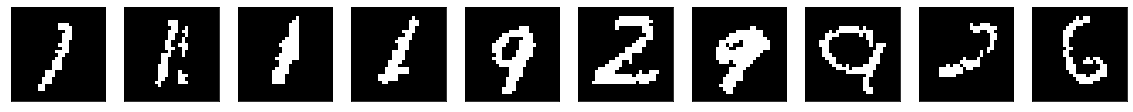

Label Predicition: [1 8 1 1 9 2 8 9 2 6]


In [26]:
print("\nMNIST Baseline\n")
print("Accuracy: " + str(mnist_baseline.evaluate_generator(mnist_baseline_val_gen)[-1]))
display_images(mnist_m2_vae_val_gen.__getitem__(0)[0][0][0:10])
print("Label Predicition: " + str(np.argmax(mnist_baseline.predict(mnist_m2_vae_val_gen.__getitem__(0)[0][0])[0:10],axis = 1)))


MNIST M2-VAE

Accuracy: 0.8551000005751849


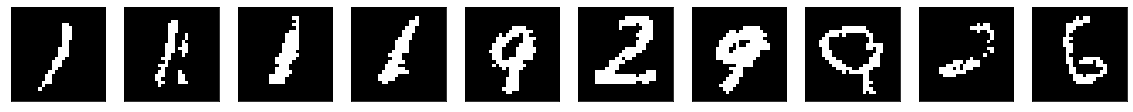

Label Predicition: [0 6 6 1 2 7 2 7 3 5]


In [27]:
print("\nMNIST M2-VAE\n")
print("Accuracy: " + str(mnist_m2_vae.evaluate_generator(mnist_m2_vae_val_gen)[-1]))
display_images(mnist_m2_vae_val_gen.__getitem__(0)[0][0][0:10])
print("Label Predicition: " + str(np.argmax(mnist_m2_vae.predict_generator
                                            (mnist_m2_vae_val_gen)[1][0:10] ,axis = -1)))

In [28]:
print("\nPascal Voc Baseline\n")
print("IOU Coefficient: " + str(pascal_voc_baseline.evaluate_generator(pascal_voc_baseline_val_gen)[-1]))


Pascal Voc Baseline

IOU Coefficient: 0.5451923538367827


In [29]:
print("\nPascal Voc M2-VAE\n")
print("IOU Coefficient: " + str(pascal_voc_m2_vae.evaluate_generator(pascal_voc_m2_vae_val_gen)[-1]))


Pascal Voc M2-VAE

IOU Coefficient: 0.5765758407312435
